Citation: <br>
We use the visualisation and utility tools provided in the following repository:
https://github.com/matterport/Mask_RCNN
<br>
<br>
The model implementation in this notebook is done by using the above repository as reference

#Importing libraries

Downloading visualisation and utility tools

In [1]:
%%capture
!wget -O archive.zip --no-check-certificate "https://drive.google.com/uc?export=download&id=1C0B1ZWuDQoODeEdEKcJFsQCKUWtnPyD8"

In [2]:
%%capture
!unzip archive.zip

In [3]:
rm ./images/.DS_Store

Importing Libraries

In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re
import math
from collections import OrderedDict
import multiprocessing
import numpy as np

import utils
import visualize
import coco
import urllib.request
import shutil

%matplotlib inline 

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as KL
import tensorflow.keras.utils as KU
from tensorflow.python.eager import context
import tensorflow.keras.models as KM
from distutils.version import LooseVersion
assert LooseVersion(tf.__version__) >= LooseVersion("2.0")


tf.compat.v1.disable_eager_execution()


#Model

##Defining sub-parts of the model

###Resnet

Default kernel size is 3

In [5]:
def resnet_graph(input_image, architecture, stage5=False, train_bn=True):
    """ ResNet graph Architecture
    """
    assert architecture in ["resnet50", "resnet101"]


    # Stage 1
    x = KL.ZeroPadding2D((3, 3))(input_image)
    x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
    x = BatchNorm(name='bn_conv1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)


    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
    C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)


    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
    C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)


    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
    block_count = {"resnet50": 5, "resnet101": 22}[architecture]
    for i in range(block_count):
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
    C4 = x

    
    # Stage 5
    if stage5:
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)
    else:
        C5 = None
    return [C1, C2, C3, C4, C5]

####Batch Normalisation

In [6]:
class BatchNorm(KL.BatchNormalization):
    """Extends the Keras BatchNormalization class """
    def call(self, inputs, training=None):
        """
        Training values:
            None: Train BN layers.
            False: Freeze BN layers.
            True: (don't use).
        """
        return super(self.__class__, self).call(inputs, training=training)


def compute_backbone_shapes(config, image_shape):
    if callable(config.BACKBONE):
        return config.COMPUTE_BACKBONE_SHAPE(image_shape)

    # Currently supports ResNet only
    assert config.BACKBONE in ["resnet50", "resnet101"]
    return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in config.BACKBONE_STRIDES])

####Convolution Block

In [7]:
def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNorm(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

####Identity block

In [8]:
def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
  
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNorm(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNorm(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

###Region Proposal Network

In [9]:
def rpn_graph(feature_map, anchors_per_location, anchor_stride):
  
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)

    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)

    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 2]))(x)

    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)

    # Bounding box refinement.
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared)

    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(input=t)[0], -1, 4]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]

In [10]:
def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """
    Builds a Keras model of the Region Proposal Network.
    """
    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return KM.Model([input_feature_map], outputs, name="rpn_model")




###Proposal layer

In [11]:
def apply_box_deltas_graph(boxes, deltas):

    # Convert to y, x, h, w
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width

    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height *= tf.exp(deltas[:, 2])
    width *= tf.exp(deltas[:, 3])
    
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result

In [12]:
def clip_boxes_graph(boxes, window):
  
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=1)
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    clipped.set_shape((clipped.shape[0], 4))
    return clipped

In [13]:
class ProposalLayer(KL.Layer):
    """Receives anchor scores and selects a subset to pass as proposals"""

    def __init__(self, proposal_count, nms_threshold, config=None, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.config = config
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold

    def get_config(self):
        config = super(ProposalLayer, self).get_config()
        config["config"] = self.config.to_dict()
        config["proposal_count"] = self.proposal_count
        config["nms_threshold"] = self.nms_threshold
        return config

    def call(self, inputs):
        scores = inputs[0][:, :, 1]
        deltas = inputs[1]
        deltas = deltas * np.reshape(self.config.RPN_BBOX_STD_DEV, [1, 1, 4])
        anchors = inputs[2]

        pre_nms_limit = tf.minimum(self.config.PRE_NMS_LIMIT, tf.shape(input=anchors)[1])
        ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,
                         name="top_anchors").indices
        scores = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        deltas = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y),
                                   self.config.IMAGES_PER_GPU)
        pre_nms_anchors = utils.batch_slice([anchors, ix], lambda a, x: tf.gather(a, x),
                                    self.config.IMAGES_PER_GPU,
                                    names=["pre_nms_anchors"])

        boxes = utils.batch_slice([pre_nms_anchors, deltas],
                                  lambda x, y: apply_box_deltas_graph(x, y),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors"])

        window = np.array([0, 0, 1, 1], dtype=np.float32)
        boxes = utils.batch_slice(boxes,
                                  lambda x: clip_boxes_graph(x, window),
                                  self.config.IMAGES_PER_GPU,
                                  names=["refined_anchors_clipped"])

        # Non-max suppression
        def nms(boxes, scores):
            indices = tf.image.non_max_suppression(
                boxes, scores, self.proposal_count,
                self.nms_threshold, name="rpn_non_max_suppression")
            proposals = tf.gather(boxes, indices)

            padding = tf.maximum(self.proposal_count - tf.shape(input=proposals)[0], 0)
            proposals = tf.pad(tensor=proposals, paddings=[(0, padding), (0, 0)])
            return proposals
        proposals = utils.batch_slice([boxes, scores], nms,
                                      self.config.IMAGES_PER_GPU)

        if not context.executing_eagerly():
            out_shape = self.compute_output_shape(None)
            proposals.set_shape(out_shape)
        return proposals

    def compute_output_shape(self, input_shape):
        return None, self.proposal_count, 4

###Feature Pyramid Network

In [14]:
def fpn_classifier_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True,
                         fc_layers_size=1024):
    """Builds the computation graph of the feature pyramid network classifier
    and regressor heads.
    """

    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_classifier")([rois, image_meta] + feature_maps)

    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (pool_size, pool_size), padding="valid"),
                           name="mrcnn_class_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)
    x = KL.TimeDistributed(KL.Conv2D(fc_layers_size, (1, 1)),
                           name="mrcnn_class_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(), name='mrcnn_class_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    shared = KL.Lambda(lambda x: K.squeeze(K.squeeze(x, 3), 2),
                       name="pool_squeeze")(x)

    # Classifier head
    mrcnn_class_logits = KL.TimeDistributed(KL.Dense(num_classes),
                                            name='mrcnn_class_logits')(shared)
    mrcnn_probs = KL.TimeDistributed(KL.Activation("softmax"),
                                     name="mrcnn_class")(mrcnn_class_logits)

    x = KL.TimeDistributed(KL.Dense(num_classes * 4, activation='linear'),
                           name='mrcnn_bbox_fc')(shared)
                           
    s = K.int_shape(x)
    if s[1] is None:
        mrcnn_bbox = KL.Reshape((-1, num_classes, 4), name="mrcnn_bbox")(x)
    else:
        mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name="mrcnn_bbox")(x)

    return mrcnn_class_logits, mrcnn_probs, mrcnn_bbox

In [15]:
def build_fpn_mask_graph(rois, feature_maps, image_meta,
                         pool_size, num_classes, train_bn=True):
    """Builds the computation graph of the mask head of Feature Pyramid Network.
    """


    x = PyramidROIAlign([pool_size, pool_size],
                        name="roi_align_mask")([rois, image_meta] + feature_maps)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv1")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn1')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv2")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn2')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv3")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn3')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                           name="mrcnn_mask_conv4")(x)
    x = KL.TimeDistributed(BatchNorm(),
                           name='mrcnn_mask_bn4')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                           name="mrcnn_mask_deconv")(x)
    x = KL.TimeDistributed(KL.Conv2D(num_classes, (1, 1), strides=1, activation="sigmoid"),
                           name="mrcnn_mask")(x)
    return x

###Region Of Interest Align (ROI Align)

In [16]:
def log2_graph(x):
    """Implementation of Log2 """
    return tf.math.log(x) / tf.math.log(2.0)

In [17]:
class PyramidROIAlign(KL.Layer):
    """Implements ROI Pooling on multiple levels of the feature pyramid.
    """

    def __init__(self, pool_shape, **kwargs):
        super(PyramidROIAlign, self).__init__(**kwargs)
        self.pool_shape = tuple(pool_shape)

    def get_config(self):
        config = super(PyramidROIAlign, self).get_config()
        config['pool_shape'] = self.pool_shape
        return config

    def call(self, inputs):
        boxes = inputs[0]

        image_meta = inputs[1]

        feature_maps = inputs[2:]

        # Assign each ROI 
        y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)
        h = y2 - y1
        w = x2 - x1

        image_shape = parse_image_meta_graph(image_meta)['image_shape'][0]

        image_area = tf.cast(image_shape[0] * image_shape[1], tf.float32)
        roi_level = log2_graph(tf.sqrt(h * w) / (224.0 / tf.sqrt(image_area)))
        roi_level = tf.minimum(5, tf.maximum(
            2, 4 + tf.cast(tf.round(roi_level), tf.int32)))
        roi_level = tf.squeeze(roi_level, 2)

        #ROI pooling to each level P2 to P5.
        pooled = []
        box_to_level = []
        for i, level in enumerate(range(2, 6)):
            ix = tf.compat.v1.where(tf.equal(roi_level, level))
            level_boxes = tf.gather_nd(boxes, ix)

            # Box indices for crop_and_resize.
            box_indices = tf.cast(ix[:, 0], tf.int32)

            # Keep track of which box is mapped to which level
            box_to_level.append(ix)

            # Stop gradient propogation to ROI proposals
            level_boxes = tf.stop_gradient(level_boxes)
            box_indices = tf.stop_gradient(box_indices)

            # Crop and Resize]
            pooled.append(tf.image.crop_and_resize(
                feature_maps[i], level_boxes, box_indices, self.pool_shape,
                method="bilinear"))

        # Pack pooled features into one tensor
        pooled = tf.concat(pooled, axis=0)

        # Pack box_to_level mapping into one array and add another
        # column representing the order of pooled boxes
        box_to_level = tf.concat(box_to_level, axis=0)
        box_range = tf.expand_dims(tf.range(tf.shape(input=box_to_level)[0]), 1)
        box_to_level = tf.concat([tf.cast(box_to_level, tf.int32), box_range],
                                 axis=1)

        # Rearrange pooled features to match the order of the original boxes
        sorting_tensor = box_to_level[:, 0] * 100000 + box_to_level[:, 1]
        ix = tf.nn.top_k(sorting_tensor, k=tf.shape(
            input=box_to_level)[0]).indices[::-1]
        ix = tf.gather(box_to_level[:, 2], ix)
        pooled = tf.gather(pooled, ix)

        # Re-add the batch dimension
        shape = tf.concat([tf.shape(input=boxes)[:2], tf.shape(input=pooled)[1:]], axis=0)
        pooled = tf.reshape(pooled, shape)
        return pooled

    def compute_output_shape(self, input_shape):
        return input_shape[0][:2] + self.pool_shape + (input_shape[2][-1], )

###Image formatting

In [18]:
def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components"""
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id,
        "original_image_shape": original_image_shape,
        "image_shape": image_shape,
        "window": window,
        "scale": scale,
        "active_class_ids": active_class_ids,
    }

In [19]:
def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta

In [20]:
def parse_image_meta(meta):
    """Parses an array that contains image attributes to its components.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id.astype(np.int32),
        "original_image_shape": original_image_shape.astype(np.int32),
        "image_shape": image_shape.astype(np.int32),
        "window": window.astype(np.int32),
        "scale": scale.astype(np.float32),
        "active_class_ids": active_class_ids.astype(np.int32),
    }

###Detection Layers

In [24]:
def refine_detections_graph(rois, probs, deltas, window, config):

    class_ids = tf.argmax(input=probs, axis=1, output_type=tf.int32)

    indices = tf.stack([tf.range(probs.shape[0]), class_ids], axis=1)
    class_scores = tf.gather_nd(probs, indices)

    deltas_specific = tf.gather_nd(deltas, indices)
    # Apply bounding box deltas
    refined_rois = apply_box_deltas_graph(
        rois, deltas_specific * config.BBOX_STD_DEV)
    # Clip boxes to image window
    refined_rois = clip_boxes_graph(refined_rois, window)

    # Filter out background boxes
    keep = tf.compat.v1.where(class_ids > 0)[:, 0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        conf_keep = tf.compat.v1.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[:, 0]
        keep = tf.sets.intersection(tf.expand_dims(keep, 0),
                                        tf.expand_dims(conf_keep, 0))
        keep = tf.sparse.to_dense(keep)[0]

    # Apply per-class NMS
    # Preparing variables
    pre_nms_class_ids = tf.gather(class_ids, keep)
    pre_nms_scores = tf.gather(class_scores, keep)
    pre_nms_rois = tf.gather(refined_rois,   keep)
    unique_pre_nms_class_ids = tf.unique(pre_nms_class_ids)[0]

    def nms_keep_map(class_id):
        """Apply Non-Maximum Suppression on ROIs of the given class."""
        ixs = tf.compat.v1.where(tf.equal(pre_nms_class_ids, class_id))[:, 0]
        # Apply NMS
        class_keep = tf.image.non_max_suppression(
                tf.gather(pre_nms_rois, ixs),
                tf.gather(pre_nms_scores, ixs),
                max_output_size=config.DETECTION_MAX_INSTANCES,
                iou_threshold=config.DETECTION_NMS_THRESHOLD)
        # Map indices
        class_keep = tf.gather(keep, tf.gather(ixs, class_keep))
        # Padding with -1 
        gap = config.DETECTION_MAX_INSTANCES - tf.shape(input=class_keep)[0]
        class_keep = tf.pad(tensor=class_keep, paddings=[(0, gap)],
                            mode='CONSTANT', constant_values=-1)
        
        class_keep.set_shape([config.DETECTION_MAX_INSTANCES])
        return class_keep

    # 2. Map over class IDs
    nms_keep = tf.map_fn(nms_keep_map, unique_pre_nms_class_ids,
                         dtype=tf.int64)
    # 3. Merge results into one list, and remove -1 padding
    nms_keep = tf.reshape(nms_keep, [-1])
    nms_keep = tf.gather(nms_keep, tf.compat.v1.where(nms_keep > -1)[:, 0])
    # 4. Compute intersection between keep and nms_keep
    keep = tf.sets.intersection(tf.expand_dims(keep, 0),
                                    tf.expand_dims(nms_keep, 0))
    keep = tf.sparse.to_dense(keep)[0]
    # Keep top detections
    roi_count = config.DETECTION_MAX_INSTANCES
    class_scores_keep = tf.gather(class_scores, keep)
    num_keep = tf.minimum(tf.shape(input=class_scores_keep)[0], roi_count)
    top_ids = tf.nn.top_k(class_scores_keep, k=num_keep, sorted=True)[1]
    keep = tf.gather(keep, top_ids)

    detections = tf.concat([
        tf.gather(refined_rois, keep),
        tf.dtypes.cast(tf.gather(class_ids, keep), tf.float32)[..., tf.newaxis],
        tf.gather(class_scores, keep)[..., tf.newaxis]
        ], axis=1)

    # Pad with zeros if detections < DETECTION_MAX_INSTANCES
    gap = config.DETECTION_MAX_INSTANCES - tf.shape(input=detections)[0]
    detections = tf.pad(tensor=detections, paddings=[(0, gap), (0, 0)], mode="CONSTANT")
    return detections

In [25]:
class DetectionLayer(KL.Layer):
    """Takes classified proposal boxes and their bounding box deltas and
    returns the final detection boxes.
    """

    def __init__(self, config=None, **kwargs):
        super(DetectionLayer, self).__init__(**kwargs)
        self.config = config

    def get_config(self):
        config = super(DetectionLayer, self).get_config()
        config["config"] = self.config.to_dict()
        return config

    def call(self, inputs):
        rois = inputs[0]
        mrcnn_class = inputs[1]
        mrcnn_bbox = inputs[2]
        image_meta = inputs[3]

        m = parse_image_meta_graph(image_meta)
        image_shape = m['image_shape'][0]
        window = norm_boxes_graph(m['window'], image_shape[:2])

        detections_batch = utils.batch_slice(
            [rois, mrcnn_class, mrcnn_bbox, window],
            lambda x, y, w, z: refine_detections_graph(x, y, w, z, self.config),
            self.config.IMAGES_PER_GPU)

        # Reshape output
        return tf.reshape(
            detections_batch,
            [self.config.BATCH_SIZE, self.config.DETECTION_MAX_INSTANCES, 6])

    def compute_output_shape(self, input_shape):
        return (None, self.config.DETECTION_MAX_INSTANCES, 6)

###Other misc functions

In [26]:
def log(text, array=None):
    """Prints a text message. And, optionally, if a Numpy array is provided it
    prints it's shape, min, and max values.
    """
    if array is not None:
        text = text.ljust(25)
        text += ("shape: {:20}  ".format(str(array.shape)))
        if array.size:
            text += ("min: {:10.5f}  max: {:10.5f}".format(array.min(),array.max()))
        else:
            text += ("min: {:10}  max: {:10}".format("",""))
        text += "  {}".format(array.dtype)
    print(text)

In [27]:
def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL

In [28]:
def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)

Model

## Implementing M-RCNN using above parts

In [29]:
class MaskRCNN(object):

    def __init__(self, mode, config, model_dir):
        assert mode in ['training', 'inference']
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)

    def build(self, mode, config):
        assert mode in ['training', 'inference']

        # Image size must be dividable by 2 multiple times
        h, w = config.IMAGE_SHAPE[:2]
        if h / 2**6 != int(h / 2**6) or w / 2**6 != int(w / 2**6):
            raise Exception("Image size must be dividable by 2 at least 6 times ")

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")
        if mode == "training":
            # RPN GT
            input_rpn_match = KL.Input(
                shape=[None, 1], name="input_rpn_match", dtype=tf.int32)
            input_rpn_bbox = KL.Input(
                shape=[None, 4], name="input_rpn_bbox", dtype=tf.float32)

            # Detection GT (class IDs, bounding boxes, and masks)
            # 1. GT Class IDs (zero padded)
            input_gt_class_ids = KL.Input(
                shape=[None], name="input_gt_class_ids", dtype=tf.int32)
            # 2. GT Boxes in pixels (zero padded)
            input_gt_boxes = KL.Input(
                shape=[None, 4], name="input_gt_boxes", dtype=tf.float32)
            # Normalize coordinates
            gt_boxes = KL.Lambda(lambda x: norm_boxes_graph(
                x, K.shape(input_image)[1:3]))(input_gt_boxes)
            # 3. GT Masks (zero padded)
            if config.USE_MINI_MASK:
                input_gt_masks = KL.Input(
                    shape=[config.MINI_MASK_SHAPE[0],
                           config.MINI_MASK_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
            else:
                input_gt_masks = KL.Input(
                    shape=[config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], None],
                    name="input_gt_masks", dtype=bool)
        elif mode == "inference":
            input_anchors = KL.Input(shape=[None, 4], name="input_anchors")

        # Build the shared convolutional layers.
        # Bottom-up Layers
        if callable(config.BACKBONE):
            _, C2, C3, C4, C5 = config.BACKBONE(input_image, stage5=True,
                                                train_bn=config.TRAIN_BN)
        else:
            _, C2, C3, C4, C5 = resnet_graph(input_image, config.BACKBONE,
                                             stage5=True, train_bn=config.TRAIN_BN)
        # Top-down Layers
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (1, 1), name='fpn_c2p2')(C2)])
        
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(config.TOP_DOWN_PYRAMID_SIZE, (3, 3), padding="SAME", name="fpn_p5")(P5)

        # P6 is used for the 5th anchor scale in RPN.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        # Anchors
        if mode == "training":
            anchors = self.get_anchors(config.IMAGE_SHAPE)
            anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
            class ConstLayer(tf.keras.layers.Layer):
                def __init__(self, x, name=None):
                    super(ConstLayer, self).__init__(name=name)
                    self.x = tf.Variable(x)

                def call(self, input):
                    return self.x

            anchors = ConstLayer(anchors, name="anchors")(input_image)
        else:
            anchors = input_anchors

        # RPN Model
        rpn = build_rpn_model(config.RPN_ANCHOR_STRIDE,
                              len(config.RPN_ANCHOR_RATIOS), config.TOP_DOWN_PYRAMID_SIZE)
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        proposal_count = config.POST_NMS_ROIS_TRAINING if mode == "training"\
            else config.POST_NMS_ROIS_INFERENCE
        rpn_rois = ProposalLayer(
            proposal_count=proposal_count,
            nms_threshold=config.RPN_NMS_THRESHOLD,
            name="ROI",
            config=config)([rpn_class, rpn_bbox, anchors])

        if mode == "training":
            active_class_ids = KL.Lambda(
                lambda x: parse_image_meta_graph(x)["active_class_ids"]
                )(input_image_meta)

            if not config.USE_RPN_ROIS:
                # Ignore predicted ROIs and use ROIs provided as an input.
                input_rois = KL.Input(shape=[config.POST_NMS_ROIS_TRAINING, 4],
                                      name="input_roi", dtype=np.int32)
                # Normalize coordinates
                target_rois = KL.Lambda(lambda x: norm_boxes_graph(
                    x, K.shape(input_image)[1:3]))(input_rois)
            else:
                target_rois = rpn_rois

            # Generate detection targets
            rois, target_class_ids, target_bbox, target_mask =\
                DetectionTargetLayer(config, name="proposal_targets")([
                    target_rois, input_gt_class_ids, gt_boxes, input_gt_masks])

            # Network Heads
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            mrcnn_mask = build_fpn_mask_graph(rois, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            output_rois = KL.Lambda(lambda x: x * 1, name="output_rois")(rois)

            # Losses
            rpn_class_loss = KL.Lambda(lambda x: rpn_class_loss_graph(*x), name="rpn_class_loss")(
                [input_rpn_match, rpn_class_logits])
            rpn_bbox_loss = KL.Lambda(lambda x: rpn_bbox_loss_graph(config, *x), name="rpn_bbox_loss")(
                [input_rpn_bbox, input_rpn_match, rpn_bbox])
            class_loss = KL.Lambda(lambda x: mrcnn_class_loss_graph(*x), name="mrcnn_class_loss")(
                [target_class_ids, mrcnn_class_logits, active_class_ids])
            bbox_loss = KL.Lambda(lambda x: mrcnn_bbox_loss_graph(*x), name="mrcnn_bbox_loss")(
                [target_bbox, target_class_ids, mrcnn_bbox])
            mask_loss = KL.Lambda(lambda x: mrcnn_mask_loss_graph(*x), name="mrcnn_mask_loss")(
                [target_mask, target_class_ids, mrcnn_mask])

            # Model
            inputs = [input_image, input_image_meta,
                      input_rpn_match, input_rpn_bbox, input_gt_class_ids, input_gt_boxes, input_gt_masks]
            if not config.USE_RPN_ROIS:
                inputs.append(input_rois)
            outputs = [rpn_class_logits, rpn_class, rpn_bbox,
                       mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,
                       rpn_rois, output_rois,
                       rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss]
            model = KM.Model(inputs, outputs, name='mask_rcnn')
        else:
            # Network Heads
            # Proposal classifier and BBox regressor 
            mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
                fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                     config.POOL_SIZE, config.NUM_CLASSES,
                                     train_bn=config.TRAIN_BN,
                                     fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

            # Detections
            detections = DetectionLayer(config, name="mrcnn_detection")(
                [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

            # Create masks for detections
            detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
            mrcnn_mask = build_fpn_mask_graph(detection_boxes, mrcnn_feature_maps,
                                              input_image_meta,
                                              config.MASK_POOL_SIZE,
                                              config.NUM_CLASSES,
                                              train_bn=config.TRAIN_BN)

            model = KM.Model([input_image, input_image_meta, input_anchors],
                             [detections, mrcnn_class, mrcnn_bbox,
                                 mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                             name='mask_rcnn')

        # Add multi-GPU support.
        if config.GPU_COUNT > 1:
            from mrcnn.parallel_model import ParallelModel
            model = ParallelModel(model, config.GPU_COUNT)

        return model

    def find_last(self):
        """Finds the last checkpoint file 
        """
        # Get directory names.
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names = filter(lambda f: f.startswith(key), dir_names)
        dir_names = sorted(dir_names)
        if not dir_names:
            import errno
            raise FileNotFoundError(
                errno.ENOENT,
                "Could not find model directory under {}".format(self.model_dir))
            
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])

        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            import errno
            raise FileNotFoundError(
                errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

    def load_weights(self, filepath, by_name=False, exclude=None):
        """Loads the weights from .h5 file
        """
        import h5py
        from tensorflow.python.keras.saving import hdf5_format

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        with h5py.File(filepath, mode='r') as f:
            if 'layer_names' not in f.attrs and 'model_weights' in f:
                f = f['model_weights']

            keras_model = self.keras_model
            layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
                else keras_model.layers

            # Exclude some layers
            if exclude:
                layers = filter(lambda l: l.name not in exclude, layers)

            if by_name:
                hdf5_format.load_weights_from_hdf5_group_by_name(f, layers)
            else:
                hdf5_format.load_weights_from_hdf5_group(f, layers)

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(
            lr=learning_rate, momentum=momentum,
            clipnorm=self.config.GRADIENT_CLIP_NORM)
        # Add Losses
        loss_names = [
            "rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (
                tf.reduce_mean(input_tensor=layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(input=w), tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            loss = (
                tf.reduce_mean(input_tensor=layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_metric(loss, name=name, aggregation='mean')

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call 
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable

            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            regex = r".*[/\\][\w-]+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})[/\\]mask\_rcnn\_[\w-]+(\d{4})\.h5"
            m = re.match(regex, str(model_path))
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                self.epoch = int(m.group(6)) - 1 + 1
                print('Re-starting from epoch %d' % self.epoch)

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. 
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model."""
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = DataGenerator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation)
        val_generator = DataGenerator(val_dataset, self.config, shuffle=True)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        if os.name == 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=workers > 1,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                min_scale=self.config.IMAGE_MIN_SCALE,
                max_dim=self.config.IMAGE_MAX_DIM,
                mode=self.config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use 
        """

        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates 
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  
        ww = wx2 - wx1  
        scale = np.array([wh, ww, wh, ww])
        
        boxes = np.divide(boxes - shift, scale)

        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area.
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_molded(self, molded_images, image_metas, verbose=0):
        """Runs the detection pipeline, but expect inputs that are
        molded already.
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(molded_images) == self.config.BATCH_SIZE,\
            "Number of images must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(molded_images)))
            for image in molded_images:
                log("image", image)

        # Validate image sizes
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape, "Images must have the same size"

        # Anchors
        anchors = self.get_anchors(image_shape)
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(molded_images):
            window = [0, 0, image.shape[0], image.shape[1]]
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       window)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def get_anchors(self, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(self.config, image_shape)
        # Cache anchors and reuse if image shape is the same
        if not hasattr(self, "_anchor_cache"):
            self._anchor_cache = {}
        if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                self.config.RPN_ANCHOR_SCALES,
                self.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                self.config.BACKBONE_STRIDES,
                self.config.RPN_ANCHOR_STRIDE)
            self.anchors = a
            # Normalize coordinates
            self._anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return self._anchor_cache[tuple(image_shape)]

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs, image_metas=None):
        """Runs a sub-set of the computation graph.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        kf = K.function(model.inputs, list(outputs.values()))

        # Prepare inputs
        if image_metas is None:
            molded_images, image_metas, _ = self.mold_inputs(images)
        else:
            molded_images = images
        image_shape = molded_images[0].shape
        # Anchors
        anchors = self.get_anchors(image_shape)
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
        model_in = [molded_images, image_metas, anchors]

        # Run inference

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np

#Loading weights and configurations

Setting root directory

In [30]:
ROOT_DIR = os.path.abspath("/content")

In [31]:
LOGS = os.path.join(ROOT_DIR, "logs")

Setting image directory

In [32]:
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Setting weights path

In [33]:
COCO_WEIGHTS = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

Downloading pretrained weights

In [34]:
PRETRAINED_WEIGHTS_URL = "https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5"

with urllib.request.urlopen(PRETRAINED_WEIGHTS_URL) as resp, open(COCO_WEIGHTS, 'wb') as out:
        shutil.copyfileobj(resp, out)

Setting the configuration

In [35]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [36]:
model = MaskRCNN(mode="inference", model_dir=LOGS, config=config)

Instructions for updating:
Use fn_output_signature instead


In [37]:
model.load_weights(COCO_WEIGHTS, by_name=True)

image: 7.jpeg
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


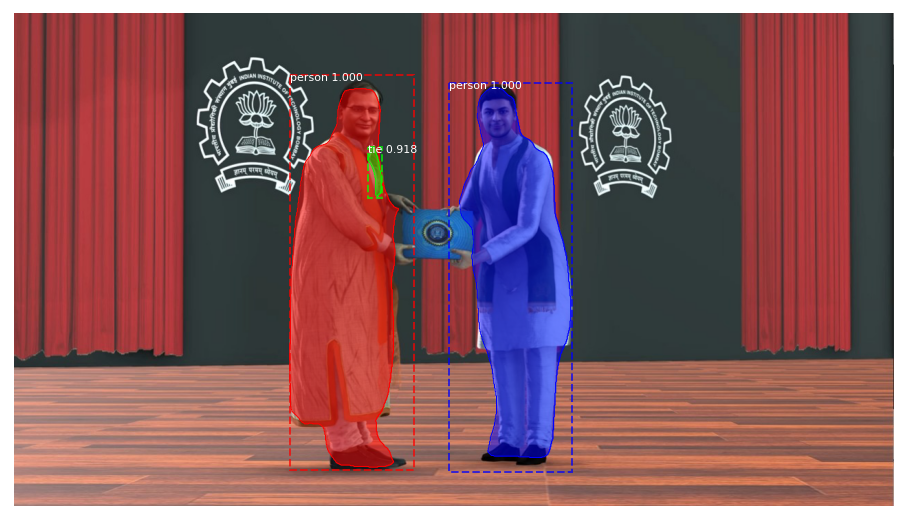

image: Icon
image: 4.jpg


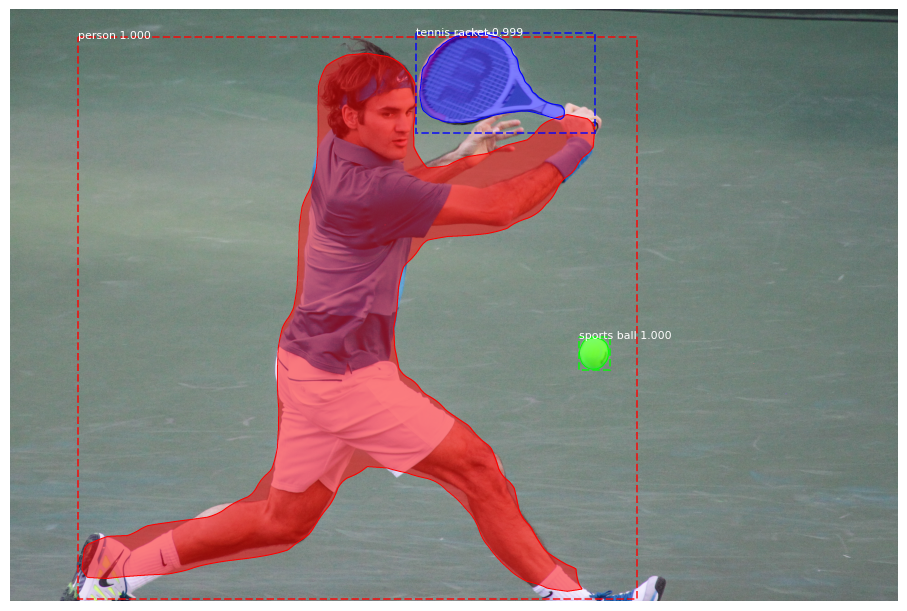

image: 6.jpg


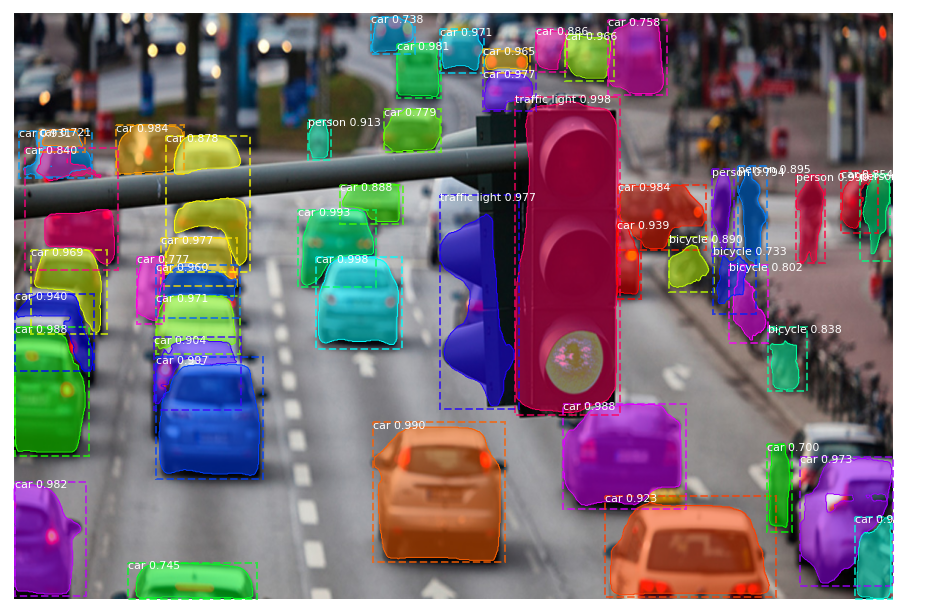

image: 1.jpg


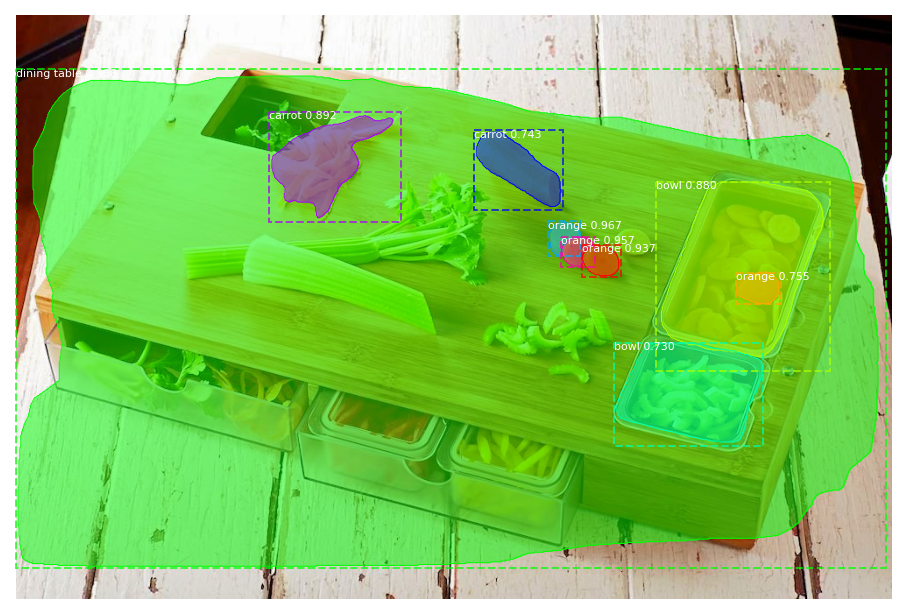

image: 3.jpeg


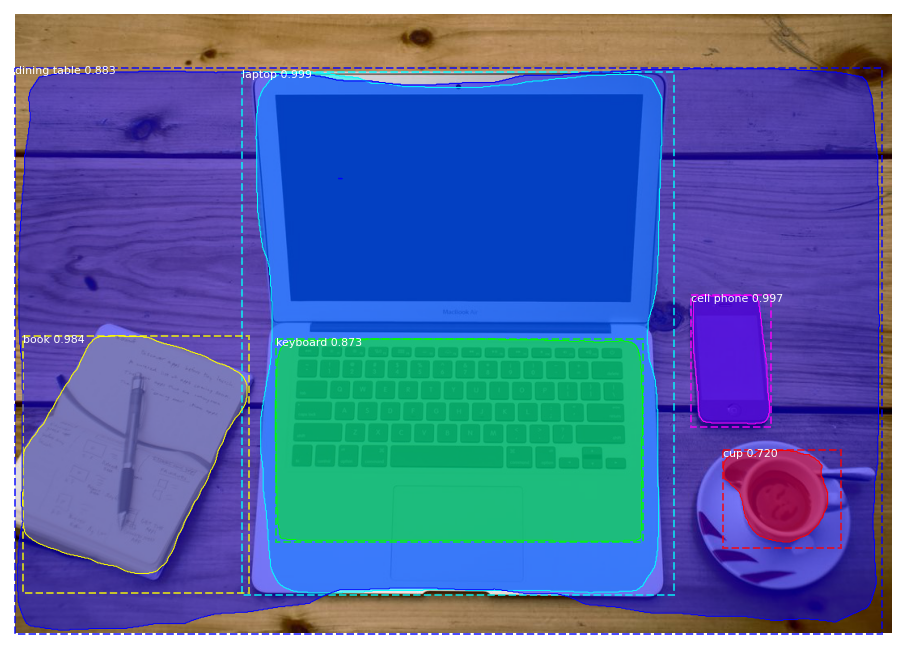

image: 2.jpeg


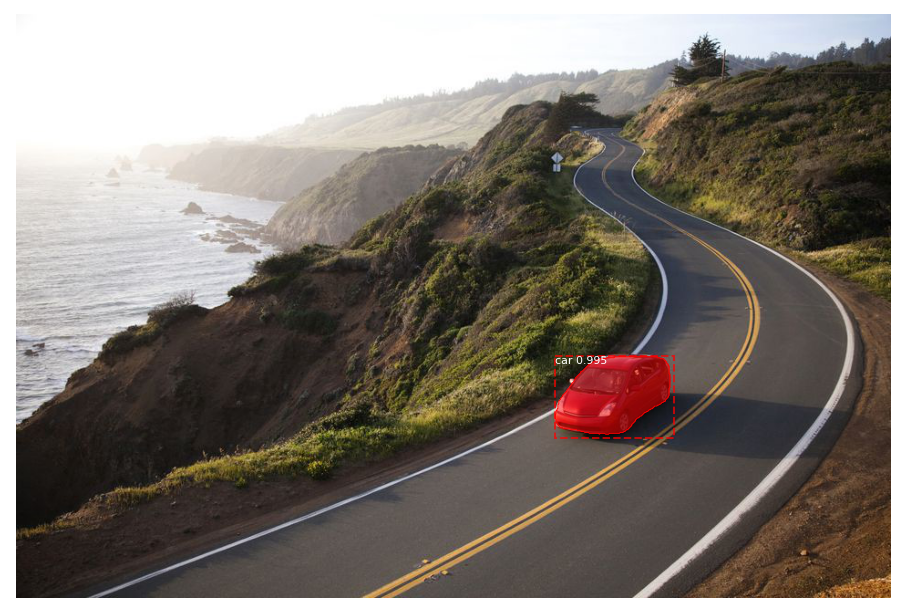

image: 5.jpeg


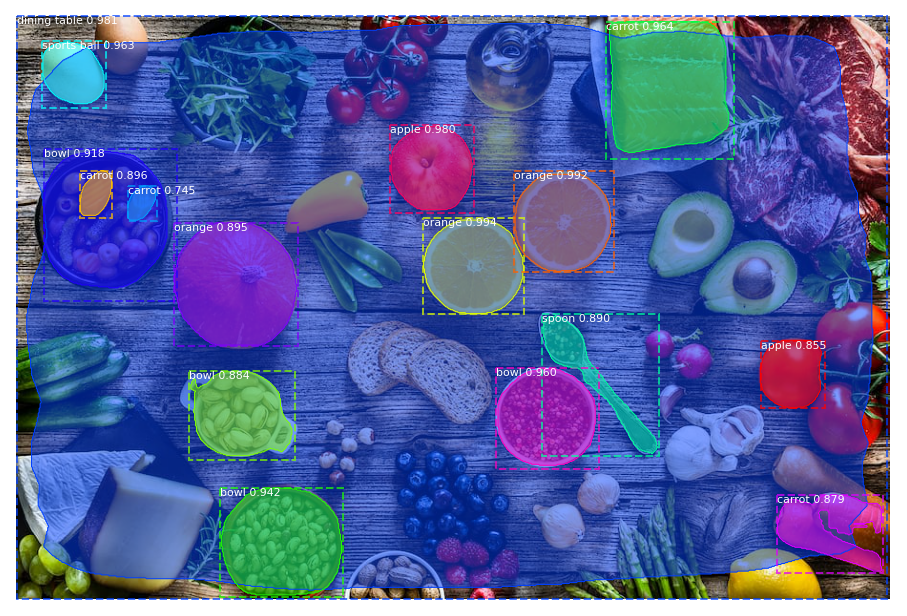

In [38]:

file_names = next(os.walk(IMAGE_DIR))[2]

for i in file_names:
  try:
    print(f"image: {i}")
    image = skimage.io.imread(os.path.join(IMAGE_DIR, i))

    # Run detection
    results = model.detect([image], verbose=0)

    # Visualize results
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])
  except:
    pass

In [ ]:
from google.colab import files

uploaded = files.upload()
image1 = skimage.io.imread(os.path.join('./', list(uploaded.keys())[0]))
results1 = model.detect([image1], verbose=0)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'], 
                            class_names, r1['scores'])